In [4]:
import sys; sys.path.insert(0, "..")  # fmt:skip

from parse_scrape import parse_scrape
from datetime import datetime, time
from pytz import timezone


matches = [
    match
    for match in parse_scrape("./scrape.jsonl")
    if match.time
    >= datetime.combine(datetime(2023, 1, 1), time.min, tzinfo=timezone("US/Pacific"))
]

In [2]:
from util import transform_coordinates
from constants import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib import colors


def gaussian_superposition(x, y, centers):
    sigma = 15
    return np.sum(
        np.exp(
            -(
                (x[..., np.newaxis] - centers[:, 0]) ** 2
                + (y[..., np.newaxis] - centers[:, 1]) ** 2
            )
            / (2 * sigma**2),
        ),
        axis=2,
    )

In [1]:
# Death heat map

map_name = BIND
player_name = STEVEN

map_image = mpimg.imread(f"assets/{map_name}.png")
scale = map_image.shape[0]

r, g, b = map_image[..., 0], map_image[..., 1], map_image[..., 2]
mask = (r == 1) & (g == 1) & (b == 1)

death_locations = np.array(
    [
        transform_coordinates(kill.victim_location, map_name, scale)
        for match in matches
        for round in match.rounds
        for kill in round.kills
        if match.map == map_name and kill.victim_name == player_name
    ]
)

x, y = np.meshgrid(np.linspace(0, scale, scale), np.linspace(0, scale, scale))
z = gaussian_superposition(x, y, death_locations)
z[mask] = -1

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.set_title(f"{player_name} deaths on {map_name}")

ax.imshow(map_image)
ax.pcolormesh(x, y, z, cmap="jet", alpha=0.5)
ax.set_axis_off()

plt.show()

NameError: name 'BIND' is not defined

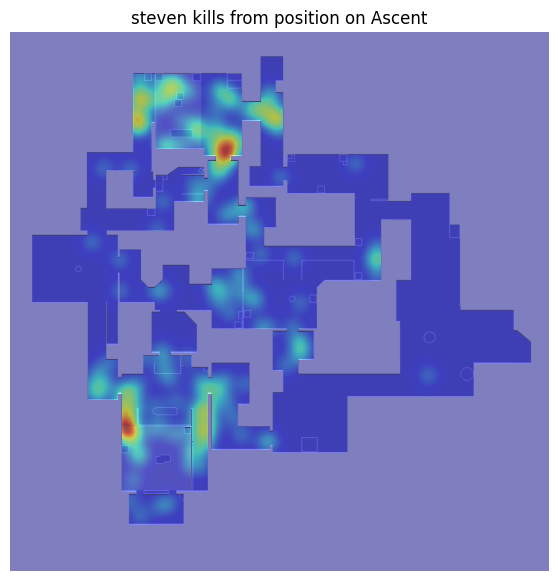

In [4]:
# Kill from position heat map

map_name = ASCENT
player_name = STEVEN

map_image = mpimg.imread(f"assets/{map_name}.png")
scale = map_image.shape[0]

r, g, b = map_image[..., 0], map_image[..., 1], map_image[..., 2]
mask = (r > 0.9) & (g > 0.9) & (b > 0.9)

kill_locations = np.array(
    [
        transform_coordinates(kill.killer_location, map_name, scale)
        for match in matches
        for round in match.rounds
        for kill in round.kills
        if match.map == map_name
        and kill.victim_name == player_name
        and kill.killer_location
    ]
)

x, y = np.meshgrid(np.linspace(0, scale, scale), np.linspace(0, scale, scale))
z = gaussian_superposition(x, y, kill_locations)
z[mask] = -1

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.set_title(f"{player_name} kills from position on {map_name}")

ax.imshow(map_image)
ax.pcolormesh(x, y, z, cmap="jet", alpha=0.5)
ax.set_axis_off()

plt.show()

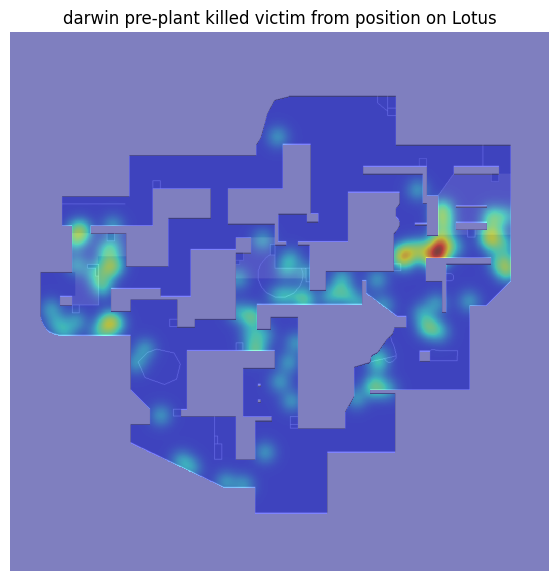

In [16]:
# Victim location heat map

map_name = LOTUS
player_name = DARWIN

map_image = mpimg.imread(f"assets/{map_name}.png")
scale = map_image.shape[0]

r, g, b = map_image[..., 0], map_image[..., 1], map_image[..., 2]
mask = (r > 0.9) & (g > 0.9) & (b > 0.9)

victim_locations = np.array(
    [
        transform_coordinates(kill.killer_location, map_name, scale)
        for match in matches
        for round in match.rounds
        for kill in round.kills
        if match.map == map_name
        and kill.killer_name == player_name
        and kill.killer_location
        and (not round.plant or kill.round_time < round.plant.round_time)
    ]
)

x, y = np.meshgrid(np.linspace(0, scale, scale), np.linspace(0, scale, scale))
z = gaussian_superposition(x, y, victim_locations)
z[mask] = -1

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.set_title(f"{player_name} pre-plant killed victim from position on {map_name}")

ax.imshow(map_image)
ax.pcolormesh(x, y, z, cmap="jet", alpha=0.5)
ax.set_axis_off()

plt.show()

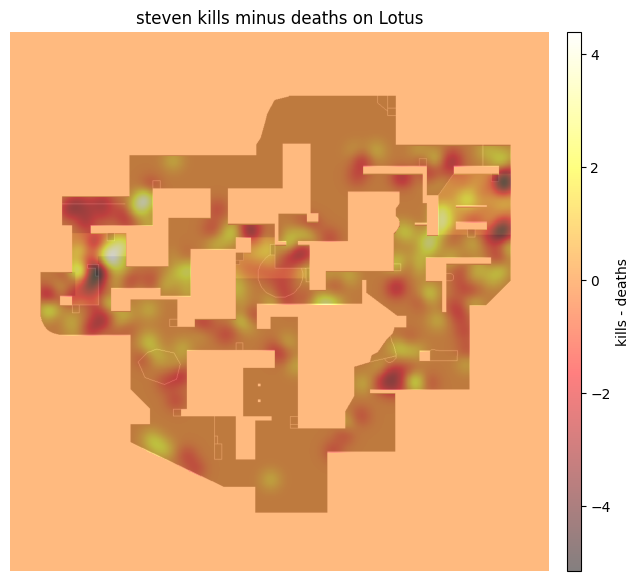

In [36]:
# Location kill success

map_name = LOTUS
player_name = STEVEN

map_image = mpimg.imread(f"assets/{map_name}.png")
scale = map_image.shape[0]

r, g, b = map_image[..., 0], map_image[..., 1], map_image[..., 2]
mask = (r > 0.9) & (g > 0.9) & (b > 0.9)

death_locations = np.array(
    [
        transform_coordinates(kill.victim_location, map_name, scale)
        for match in matches
        for round in match.rounds
        for kill in round.kills
        if match.map == map_name and kill.victim_name == player_name
    ]
)

kill_locations = np.array(
    [
        transform_coordinates(kill.killer_location, map_name, scale)
        for match in matches
        for round in match.rounds
        for kill in round.kills
        if match.map == map_name
        and kill.victim_name == player_name
        and kill.killer_location
    ]
)

x, y = np.meshgrid(np.linspace(0, scale, scale), np.linspace(0, scale, scale))

z_deaths = gaussian_superposition(x, y, death_locations)
z_kills = gaussian_superposition(x, y, kill_locations)
z_kills[mask] = -1
z_deaths[mask] = -1

z = z_kills - z_deaths

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot()

ax.set_title(f"{player_name} kills minus deaths on {map_name}")
ax.set_axis_off()

ax.imshow(map_image)

co = ax.pcolormesh(x, y, z, cmap=plt.cm.hot, alpha=0.5)
cax = fig.add_axes(
    (ax.get_position().x1 + 0.025, ax.get_position().y0, 0.02, ax.get_position().height)
)
fig.colorbar(co, cax, label="kills - deaths")

plt.show()